In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import skimage
import pydicom
import cv2
from tqdm import tqdm
import sys
from pydicom.pixel_data_handlers.util import apply_modality_lut
import torch
import torch.nn.functional as F

from argparse import Namespace
from pytorch_lightning.utilities.cloud_io import load as pl_load

In [2]:
sys.path.append(os.path.realpath('..'))
from sybilx.datasets.nlst import NLSTCTProjectionsDataset
from sybilx.datasets.nlst_xray import NLST_XRay_Dataset
from sybilx.datasets.plco_xray import PLCO_NLST_Smokers_Dataset, PLCO_XRay_Dataset, PLCO_XRay_Smokers_Dataset
from sybilx.utils.registry import get_object
import sybilx.utils.loading as loaders

## NLST X-Rays Statistics

In [3]:
true = True
false = False

In [4]:
config = {
    "dataset": ["plco_xray"],
    "loss_fns": ["cross_entropy"],
    "num_classes": [2],
    "metrics": ["classification"],
    "monitor": ["val_roc_auc"],
    "input_loader_name": ["tif_loader"],
    "img_file_type": ['tif'],
    "accumulate_grad_batches": [1],
    "workspace": ["itamar"],
    "project_name": ["xray-cancer"],
    "lightning_name": ["base"],
    "patience": [5],
    "num_workers": [8],
    "fix_seed_for_multi_image_augmentations": [true],
    "num_chan": [3],
    "num_sanity_val_steps": [0],
    "use_risk_factors": [true],
    "val_check_interval": [1.0],
    "ignore_warnings": [false],
    "cross_val_seed": [0],
    "assign_splits": [true],
    "split_type": ["random"],
    "split_probs": [[0.7, 0.15, 0.15]],
    "limit_train_batches": [1.0],
    "limit_val_batches": [1.0],
    "gpus": [1],
    "precision": [16],
    "max_followup": [12],
    "batch_size": [32],
    "img_size": [[512, 512]],
    "max_epochs": [10],
    "lr_decay": [0.1],
    "lr": [1e-3],
    "base_model": ["simple_sybilx_r50"],
    "use_annotations": [false],
    "optimizer": ["sgd"],
    "momentum": [0.9],
    "train": [true],
    "dev": [true],
    "test": [true],
    "class_bal": [true],
    "train_rawinput_augmentations": [[("scale_2d", {}), ("rotate_range", {"deg":20})]],
    "train_tnsr_augmentations": [[("force_num_chan_2d", {}), ("normalize_2d", {})]],
    "test_rawinput_augmentations": [[("scale_2d", {})]],
    "test_tnsr_augmentations": [[("force_num_chan_2d", {}), ("normalize_2d", {})]],
    "img_mean": [[2863.070033296751]],
    "img_std": [[887.966694489157]],
    "dataset_file_path": ["/storage/ludvig/PLCO_XRAY/metadata_2022_04_05_rotated.json"],
    "save_dir": ["/storage/itamar/snapshots"],
    "cache_path": ["/storage/xray_cache"],
    "scheduler": ["reduce_on_plateau"],
    "dropout": [0.1],
    "weight_decay": [0.1],
    "comet_tags": ["plco simple_sybilx_r50 dropout wd momentum v2 lr_wd_drop_experiments"],
    "filter_derived_images": [false],
    "filter_post_processed_images": [false],
    "class_bal_key": ['y'],
    "plco_train_study_yrs": [None],
    "plco_test_study_yrs": [None],
    "plco_use_only_visitnum": [None],
    "plco_use_only_one_image": [False],
    "min_img_width":[None],
    "max_img_width":[None],
    "min_img_height":[None],
    "max_img_height": [None],
    "hidden_size": [256],
    "relax_checkpoint_matching": [False],
    "accelerator": [None],
#     "snapshot": "/storage/itamar/snapshots/528a4cd1cd28dffe84cd720a2c36ffd0/528a4cd1cd28dffe84cd720a2c36ffd0epoch=2.ckpt"
}
config = {k: v[0] for k,v in config.items()}

In [5]:
args = Namespace(**config)

In [6]:
args

Namespace(accelerator=None, accumulate_grad_batches=1, assign_splits=True, base_model='simple_sybilx_r50', batch_size=32, cache_path='/storage/xray_cache', class_bal=True, class_bal_key='y', comet_tags='plco simple_sybilx_r50 dropout wd momentum v2 lr_wd_drop_experiments', cross_val_seed=0, dataset='plco_xray', dataset_file_path='/storage/ludvig/PLCO_XRAY/metadata_2022_04_05_rotated.json', dev=True, dropout=0.1, filter_derived_images=False, filter_post_processed_images=False, fix_seed_for_multi_image_augmentations=True, gpus=1, hidden_size=256, ignore_warnings=False, img_file_type='tif', img_mean=[2863.070033296751], img_size=[512, 512], img_std=[887.966694489157], input_loader_name='tif_loader', lightning_name='base', limit_train_batches=1.0, limit_val_batches=1.0, loss_fns='cross_entropy', lr=0.001, lr_decay=0.1, max_epochs=10, max_followup=12, max_img_height=None, max_img_width=None, metrics='classification', min_img_height=None, min_img_width=None, momentum=0.9, monitor='val_roc_au

In [7]:
train_dataset = loaders.get_train_dataset_loader(
        args, get_object(args.dataset, "dataset")(args, "train")
    )
dev_dataset = loaders.get_eval_dataset_loader(
    args, get_object(args.dataset, "dataset")(args, "dev"), False
)
    
test_dataset = loaders.get_eval_dataset_loader(
    args, get_object(args.dataset, "dataset")(args, "test"), False
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:01<00:00, 15156.54it/s]


Contructed PLCO X-Ray Cancer Risk train dataset with 63005 records, 59098 exams, 17524 patients, and the following class balance 
 Counter({0: 60822, 1: 2183})
Censor Times: Counter({11: 28063, 10: 9040, 9: 8012, 8: 6381, 7: 4045, 6: 2135, 5: 1247, 3: 913, 4: 907, 2: 877, 1: 754, 0: 631})
Class counts are: Counter({0: 60822, 1: 2183})
Label weights are {0: 8.220709611653678e-06, 1: 0.00022904260192395785}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 73713.91it/s]


Contructed PLCO X-Ray Cancer Risk dev dataset with 13241 records, 12395 exams, 3683 patients, and the following class balance 
 Counter({0: 12786, 1: 455})
Censor Times: Counter({11: 5906, 10: 1849, 9: 1688, 8: 1361, 7: 908, 6: 485, 5: 233, 4: 189, 3: 175, 2: 163, 1: 149, 0: 135})
Class counts are: Counter({0: 12786, 1: 455})
Label weights are {0: 3.9105271390583454e-05, 1: 0.001098901098901099}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 68341.86it/s]

Contructed PLCO X-Ray Cancer Risk test dataset with 13416 records, 12609 exams, 3763 patients, and the following class balance 
 Counter({0: 12920, 1: 496})
Censor Times: Counter({11: 5812, 10: 1907, 9: 1739, 8: 1383, 7: 879, 6: 517, 5: 279, 2: 199, 4: 186, 0: 173, 1: 171, 3: 171})
Class counts are: Counter({0: 12920, 1: 496})
Label weights are {0: 3.869969040247678e-05, 1: 0.0010080645161290322}


In [8]:
def load_snapshot(snapshot_path):
    args.snapshot = snapshot_path
    model = get_object(args.lightning_name, "lightning")(args)
    if snapshot_path != 'random_init':
        modelpath = args.snapshot
        checkpoint = pl_load(
            args.snapshot, map_location=lambda storage, loc: storage
        )
        snargs = checkpoint["hyper_parameters"]["args"]

        model = model.load_from_checkpoint(
            checkpoint_path=modelpath,
            strict=not args.relax_checkpoint_matching,
            **{"args": args}
        )
    model.eval()
    return model

In [9]:
model = load_snapshot("/storage/itamar/snapshots/528a4cd1cd28dffe84cd720a2c36ffd0/528a4cd1cd28dffe84cd720a2c36ffd0epoch=2.ckpt") 

In [10]:
from sybilx.learning.losses.basic import get_cross_entropy_loss
from sybilx.learning.metrics import basic

## Train Data

In [11]:
institution, probs, preds, golds = [], [], [], []
# i = 0
for batch_idx, batch in tqdm(enumerate(train_dataset), total=len(train_dataset)):
    out = model.model(batch['x'])
    loss, logging_dict, predictions = get_cross_entropy_loss(out, batch, model.model, args)
    institution.append(batch['institution'])
    probs.append(predictions['probs'])
    preds.append(predictions['preds'])
    golds.append(predictions['golds'])
#     i += 1
#     if i >= 10 :
#         break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1969/1969 [1:22:54<00:00,  2.53s/it]


In [12]:
institution = torch.concat(institution)
probs = torch.concat(probs)
preds = torch.concat(preds) 
golds = torch.concat(golds)

In [13]:
institution.shape, probs.shape, preds.shape, golds.shape

(torch.Size([63005]),
 torch.Size([63005, 2]),
 torch.Size([63005]),
 torch.Size([63005]))

In [17]:
metrics = get_object("classification", "metric")(args)
institution_metrics = {}
for institution_num in set(institution.tolist()):
    indx = np.where(institution == institution_num)
    class_metrics = metrics({'probs': probs[indx],
                   "preds": preds[indx],
                   "golds": golds[indx]},
                  args)
    institution_metrics[institution_num] = class_metrics
    print(f"Institution num {institution_num}")
    print(class_metrics)

Institution num 1
OrderedDict([('accuracy', tensor(0.7425)), ('confusion_matrix', tensor([[2220,  272],
        [ 803,  879]])), ('precision', tensor(0.7637)), ('recall', tensor(0.5226)), ('f1', tensor(0.6205)), ('pr_auc', tensor(0.7174)), ('roc_auc', tensor(0.8208))])
Institution num 2
OrderedDict([('accuracy', tensor(0.6547)), ('confusion_matrix', tensor([[1296,  464],
        [ 700,  911]])), ('precision', tensor(0.6625)), ('recall', tensor(0.5655)), ('f1', tensor(0.6102)), ('pr_auc', tensor(0.6829)), ('roc_auc', tensor(0.7085))])
Institution num 3
OrderedDict([('accuracy', tensor(0.7694)), ('confusion_matrix', tensor([[2133,  317],
        [ 706, 1281]])), ('precision', tensor(0.8016)), ('recall', tensor(0.6447)), ('f1', tensor(0.7146)), ('pr_auc', tensor(0.7920)), ('roc_auc', tensor(0.8366))])
Institution num 4
OrderedDict([('accuracy', tensor(0.7096)), ('confusion_matrix', tensor([[5718,  945],
        [2714, 3222]])), ('precision', tensor(0.7732)), ('recall', tensor(0.5428)), ('

/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/deprecate/deprecation.py:115: FutureWarning: The `f1` was deprecated since v0.7 in favor of `torchmetrics.functional.classification.f_beta.f1_score`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


In [18]:
import matplotlib.pyplot as plt

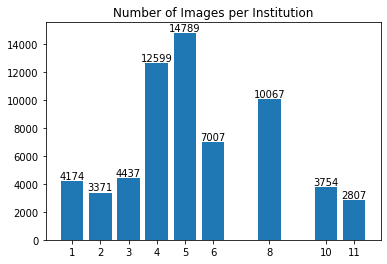

In [55]:
title = "Number of Images per Institution (Train)"
plt.title(title)
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [len(np.where(institution == institution_num)[0]) for institution_num in institution_metrics.keys()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [len(np.where(institution == institution_num)[0]) for institution_num in institution_metrics.keys()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

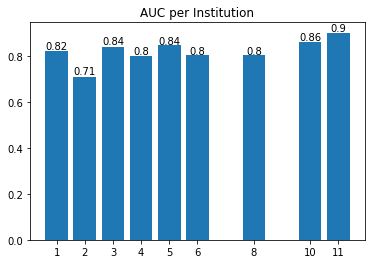

In [58]:
# fig, ax = plt.plot()
title = "AUC per Institution (Train)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['roc_auc'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['roc_auc'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

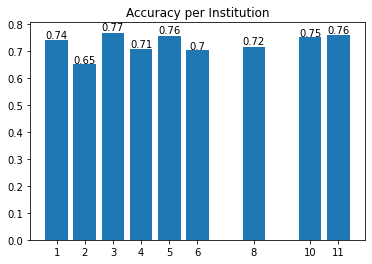

In [52]:
title = "Accuracy per Institution (Train)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['accuracy'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['accuracy'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

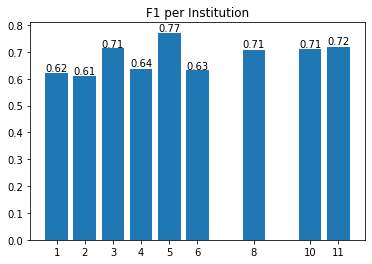

In [53]:
title = "F1 per Institution (Train)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['f1'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['f1'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

## Dev Data

In [59]:
institution, probs, preds, golds = [], [], [], []
# i = 0
for batch_idx, batch in tqdm(enumerate(dev_dataset), total=len(dev_dataset)):
    out = model.model(batch['x'])
    loss, logging_dict, predictions = get_cross_entropy_loss(out, batch, model.model, args)
    institution.append(batch['institution'])
    probs.append(predictions['probs'])
    preds.append(predictions['preds'])
    golds.append(predictions['golds'])
#     i += 1
#     if i >= 10 :
#         break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [16:47<00:00,  2.43s/it]


In [60]:
institution = torch.concat(institution)
probs = torch.concat(probs)
preds = torch.concat(preds) 
golds = torch.concat(golds)

In [61]:
institution.shape, probs.shape, preds.shape, golds.shape

(torch.Size([13241]),
 torch.Size([13241, 2]),
 torch.Size([13241]),
 torch.Size([13241]))

In [62]:
metrics = get_object("classification", "metric")(args)
institution_metrics = {}
for institution_num in set(institution.tolist()):
    indx = np.where(institution == institution_num)
    class_metrics = metrics({'probs': probs[indx],
                   "preds": preds[indx],
                   "golds": golds[indx]},
                  args)
    institution_metrics[institution_num] = class_metrics
    print(f"Institution num {institution_num}")
    print(class_metrics)

Institution num 1
OrderedDict([('accuracy', tensor(0.8861)), ('confusion_matrix', tensor([[954, 100],
        [ 24,  11]])), ('precision', tensor(0.0991)), ('recall', tensor(0.3143)), ('f1', tensor(0.1507)), ('pr_auc', tensor(0.0748)), ('roc_auc', tensor(0.6520))])
Institution num 2
OrderedDict([('accuracy', tensor(0.7889)), ('confusion_matrix', tensor([[676, 167],
        [ 16,   8]])), ('precision', tensor(0.0457)), ('recall', tensor(0.3333)), ('f1', tensor(0.0804)), ('pr_auc', tensor(0.1136)), ('roc_auc', tensor(0.6652))])
Institution num 3
OrderedDict([('accuracy', tensor(0.8356)), ('confusion_matrix', tensor([[790, 138],
        [ 20,  13]])), ('precision', tensor(0.0861)), ('recall', tensor(0.3939)), ('f1', tensor(0.1413)), ('pr_auc', tensor(0.0820)), ('roc_auc', tensor(0.7446))])
Institution num 4
OrderedDict([('accuracy', tensor(0.8207)), ('confusion_matrix', tensor([[2258,  451],
        [  49,   30]])), ('precision', tensor(0.0624)), ('recall', tensor(0.3797)), ('f1', tensor(

In [63]:
import matplotlib.pyplot as plt

In [64]:
institution

tensor([11, 11, 11,  ...,  4,  4,  4])

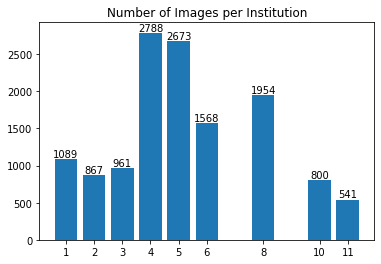

In [65]:
title = "Number of Images per Institution (Dev)"
plt.title(title)
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [len(np.where(institution == institution_num)[0]) for institution_num in institution_metrics.keys()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [len(np.where(institution == institution_num)[0]) for institution_num in institution_metrics.keys()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

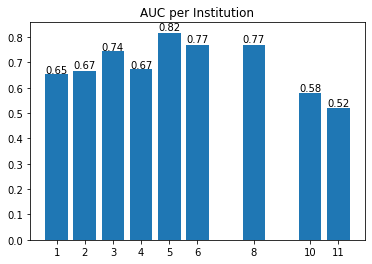

In [66]:
# fig, ax = plt.plot()
title = "AUC per Institution (Dev)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['roc_auc'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['roc_auc'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

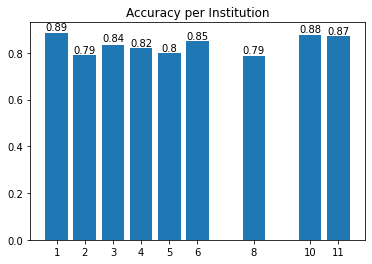

In [67]:
title = "Accuracy per Institution (Dev)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['accuracy'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['accuracy'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

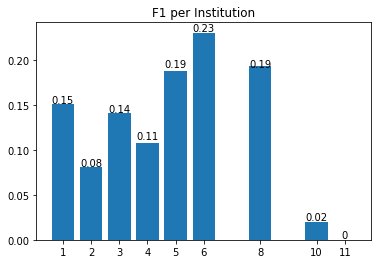

In [68]:
title = "F1 per Institution (Dev)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['f1'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['f1'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

## Test Data

In [69]:
institution, probs, preds, golds = [], [], [], []
# i = 0
for batch_idx, batch in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    out = model.model(batch['x'])
    loss, logging_dict, predictions = get_cross_entropy_loss(out, batch, model.model, args)
    institution.append(batch['institution'])
    probs.append(predictions['probs'])
    preds.append(predictions['preds'])
    golds.append(predictions['golds'])
#     i += 1
#     if i >= 10 :
#         break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [20:55<00:00,  2.99s/it]


In [70]:
institution = torch.concat(institution)
probs = torch.concat(probs)
preds = torch.concat(preds) 
golds = torch.concat(golds)

In [71]:
institution.shape, probs.shape, preds.shape, golds.shape

(torch.Size([13416]),
 torch.Size([13416, 2]),
 torch.Size([13416]),
 torch.Size([13416]))

In [72]:
metrics = get_object("classification", "metric")(args)
institution_metrics = {}
for institution_num in set(institution.tolist()):
    indx = np.where(institution == institution_num)
    class_metrics = metrics({'probs': probs[indx],
                   "preds": preds[indx],
                   "golds": golds[indx]},
                  args)
    institution_metrics[institution_num] = class_metrics
    print(f"Institution num {institution_num}")
    print(class_metrics)

Institution num 1
OrderedDict([('accuracy', tensor(0.8874)), ('confusion_matrix', tensor([[907, 108],
        [  8,   7]])), ('precision', tensor(0.0609)), ('recall', tensor(0.4667)), ('f1', tensor(0.1077)), ('pr_auc', tensor(0.0766)), ('roc_auc', tensor(0.7861))])
Institution num 2
OrderedDict([('accuracy', tensor(0.7768)), ('confusion_matrix', tensor([[659, 177],
        [ 17,  16]])), ('precision', tensor(0.0829)), ('recall', tensor(0.4848)), ('f1', tensor(0.1416)), ('pr_auc', tensor(0.1150)), ('roc_auc', tensor(0.6990))])
Institution num 3
OrderedDict([('accuracy', tensor(0.8413)), ('confusion_matrix', tensor([[796, 139],
        [ 14,  15]])), ('precision', tensor(0.0974)), ('recall', tensor(0.5172)), ('f1', tensor(0.1639)), ('pr_auc', tensor(0.0933)), ('roc_auc', tensor(0.7048))])
Institution num 4
OrderedDict([('accuracy', tensor(0.8274)), ('confusion_matrix', tensor([[2390,  469],
        [  37,   35]])), ('precision', tensor(0.0694)), ('recall', tensor(0.4861)), ('f1', tensor(

In [73]:
import matplotlib.pyplot as plt

In [74]:
institution

tensor([11, 11, 11,  ..., 11,  4,  4])

In [ ]:
title = "Number of Images per Institution (Test)"
plt.title(title)
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [len(np.where(institution == institution_num)[0]) for institution_num in institution_metrics.keys()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [len(np.where(institution == institution_num)[0]) for institution_num in institution_metrics.keys()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

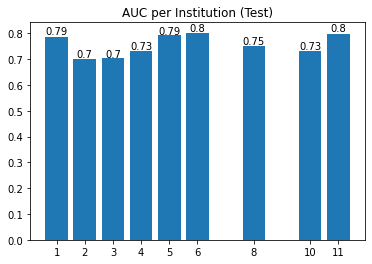

In [79]:
# fig, ax = plt.plot()
title = "AUC per Institution (Test)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['roc_auc'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['roc_auc'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

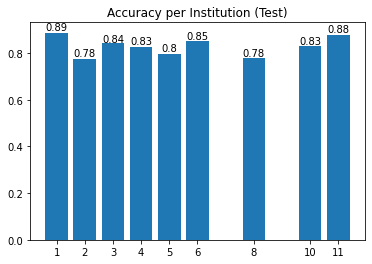

In [80]:
title = "Accuracy per Institution (Test)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['accuracy'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['accuracy'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()

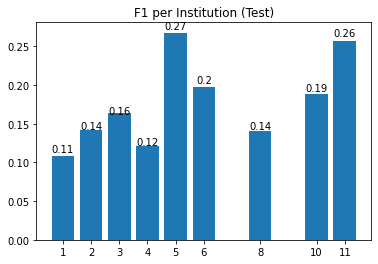

In [81]:
title = "F1 per Institution (Test)"
plt.title(title)
bars = ax.bar(list(institution_metrics.keys()), [np.round(m['f1'], 2) for m in institution_metrics.values()])
plt.bar_label(bars)
plt.bar(list(institution_metrics.keys()), [m['f1'] for m in institution_metrics.values()], 
        width=0.8, tick_label=list(institution_metrics.keys()))
plt.show()